torch.Size([3, 3])
torch.Size([2, 3])
DataBatch(x=[3, 6], edge_index=[2, 0], y=[3, 3], pos=[3, 3], batch=[3], grid_pos=[27, 3], grid_x=[27, 6], grid_edges=[2, 3], grid_neighbors=[2, 108], ptr=[2])


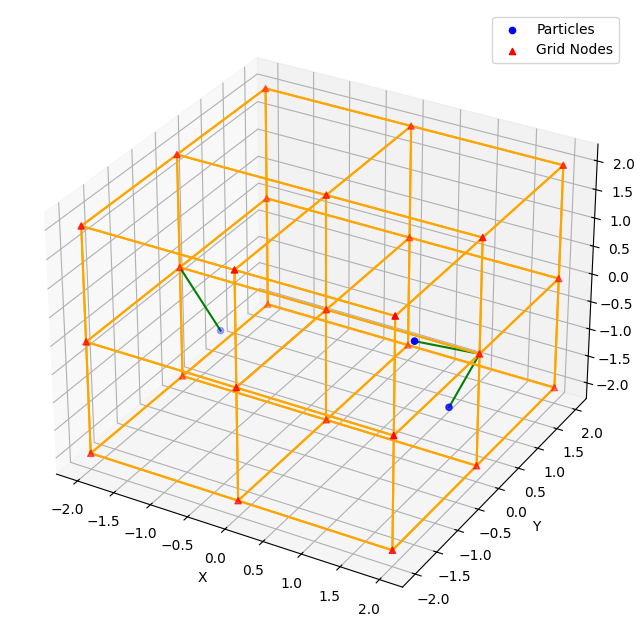

In [76]:
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.nn import radius_graph
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def transform_to_graph(positions, features, y, radius=1, edge_attr=False, device='cuda', U=None, K=None, grid_size=3, space_dim=(-2, 2)):
    batch = []
    if positions.dim() == 2:
        positions = positions.unsqueeze(0)
    
    grid_min, grid_max = space_dim
    grid_step = (grid_max - grid_min) / (grid_size - 1) + 1e-6
    
    for i in range(positions.size(0)):
        print(positions[i].shape)
        pos = positions[i]
        edge_index = radius_graph(pos, r=radius, batch=None, loop=False, max_num_neighbors=100)
        x_feats = torch.cat((pos, features[i]), dim=-1)
        data = Data(pos=pos, edge_index=edge_index, x=x_feats, y=y[i])
        batch_idx = torch.full((pos.size(0),), i, dtype=torch.long, device=device)
        data.batch = batch_idx
        
        if U is not None:
            data.U = U[i]
            data.K = K[i]

        if edge_attr:
            attr = (pos[edge_index[0]] - pos[edge_index[1]]).norm(dim=-1).unsqueeze(-1)
            masses = data.x[:, 3].reshape(-1, 1)
            mass_mul = masses[edge_index[0]] * masses[edge_index[1]]
            attr = torch.cat((attr, mass_mul), dim=-1)
            data.edge_attr = attr
        
        # Create regular grid nodes
        grid_coords = torch.meshgrid(
            torch.linspace(grid_min, grid_max, grid_size),
            torch.linspace(grid_min, grid_max, grid_size),
            torch.linspace(grid_min, grid_max, grid_size),
            indexing='ij'
        )
        grid_pos = torch.stack([grid_coords[0].flatten(), grid_coords[1].flatten(), grid_coords[2].flatten()], dim=-1).to(device)
        
        grid_features = torch.zeros((grid_pos.shape[0], x_feats.shape[-1]), device=device)
        
        
        # Connect particles to grid nodes
        grid_edges = []
        for idx, p in enumerate(pos):
            distances = torch.norm(grid_pos - p, dim=-1)
            closest_idx = torch.argmin(distances)
            grid_edges.append([idx, closest_idx])
            grid_features[closest_idx] += x_feats[idx]
        grid_edges = torch.tensor(grid_edges, dtype=torch.long).T.to(device)
        print(grid_edges.shape)
        
        # Connect neighboring grid nodes
        grid_neighbors = radius_graph(grid_pos, r=grid_step, loop=False)
        
        # Store grid-related attributes separately
        data.grid_pos = grid_pos
        data.grid_x = grid_features
        data.grid_edges = grid_edges
        data.grid_neighbors = grid_neighbors
        
        batch.append(data)
    
    return Batch.from_data_list(batch).to(device)

def test_and_plot():
    positions = torch.rand((1,3, 3)) * 4 - 2
    features = torch.rand((1,3, 3))
    y = torch.rand((1,3, 3))
    
    graph = transform_to_graph(positions, features, y, device='cpu')
    print(graph)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    try:
        # Plot particle nodes
        ax.scatter(graph.pos[:, 0], graph.pos[:, 1], graph.pos[:, 2], c='b', label='Particles')
        
        # Plot grid nodes
        ax.scatter(graph.grid_pos[:, 0], graph.grid_pos[:, 1], graph.grid_pos[:, 2], c='r', marker='^', label='Grid Nodes')
        
        # Plot radius graph edges (black)
        for i in range(graph.edge_index.shape[1]):
            src, dst = graph.edge_index[:, i]
            ax.plot([graph.pos[src, 0], graph.pos[dst, 0]],
                    [graph.pos[src, 1], graph.pos[dst, 1]],
                    [graph.pos[src, 2], graph.pos[dst, 2]], c='k')
        
        # Plot particle-to-grid edges (green)
        for i in range(graph.grid_edges.shape[1]):
            p_idx, g_idx = graph.grid_edges[:, i]
            ax.plot([graph.pos[p_idx, 0], graph.grid_pos[g_idx, 0]],
                    [graph.pos[p_idx, 1], graph.grid_pos[g_idx, 1]],
                    [graph.pos[p_idx, 2], graph.grid_pos[g_idx, 2]], c='g')
        
        # Plot grid neighbor edges (orange)
        for i in range(graph.grid_neighbors.shape[1]):
            src, dst = graph.grid_neighbors[:, i]
            ax.plot([graph.grid_pos[src, 0], graph.grid_pos[dst, 0]],
                    [graph.grid_pos[src, 1], graph.grid_pos[dst, 1]],
                    [graph.grid_pos[src, 2], graph.grid_pos[dst, 2]], c='orange')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.legend()
        plt.show()
    except:
        pass

    return graph

G = test_and_plot()



In [77]:
G.grid_edges

tensor([[ 0,  1,  2],
        [ 4, 22, 22]])

In [78]:
G.batch

tensor([0, 0, 0])

In [79]:
G.edge_index

tensor([], size=(2, 0), dtype=torch.int64)

In [85]:
G.grid_edges # it is from node to grid node

tensor([[ 0,  1,  2],
        [ 4, 22, 22]])

In [81]:
G.x

tensor([[-1.4740,  0.0421, -0.9785,  0.5806,  0.8638,  0.7204],
        [ 1.4663, -0.5630,  0.3972,  0.2187,  0.9021,  0.3463],
        [ 1.7117, -0.1650, -0.9457,  0.7256,  0.3831,  0.3213]])

In [82]:
G.grid_x

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.4740,  0.0421, -0.9785,  0.5806,  0.8638,  0.7204],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0

In [83]:
G.x[G.grid_edges[0]]

tensor([[-1.4740,  0.0421, -0.9785,  0.5806,  0.8638,  0.7204],
        [ 1.4663, -0.5630,  0.3972,  0.2187,  0.9021,  0.3463],
        [ 1.7117, -0.1650, -0.9457,  0.7256,  0.3831,  0.3213]])

In [86]:
G.grid_x[G.grid_edges[1]]

tensor([[-1.4740,  0.0421, -0.9785,  0.5806,  0.8638,  0.7204],
        [ 3.1779, -0.7281, -0.5485,  0.9443,  1.2852,  0.6676],
        [ 3.1779, -0.7281, -0.5485,  0.9443,  1.2852,  0.6676]])

In [ ]:
from old_stuff.simulator import Simulator, generateDisk3Dv3
import torch
from old_stuff.generation import generate_scene_multidisk
from old_stuff.visualization import animate_scene



In [8]:
scene, masses = generate_scene_multidisk(2, frames=2500, device='cuda', dt=0.1)

In [9]:
positions = torch.stack([r['positions'] for r in scene], dim=0)
positions.shape, masses.shape

(torch.Size([2501, 502, 3]), torch.Size([502]))

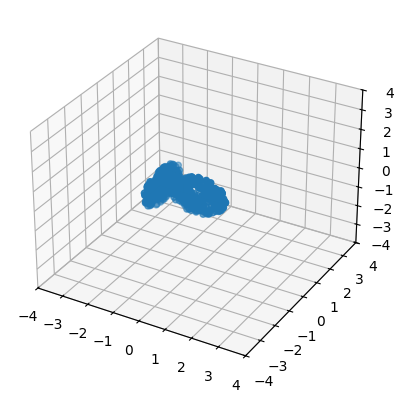

In [10]:
ani = animate_scene(positions=positions)

In [11]:
from IPython.display import HTML

In [ ]:
HTML(ani.to_jshtml())

Animation size has reached 21063100 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [3]:
pos = result[0]['positions']
pos

tensor([[-7.3611e-01, -5.6225e-01, -1.9840e-02],
        [-8.3674e-01, -5.0206e-01, -8.0368e-01],
        [-1.4353e-01, -8.0971e-01,  1.0037e-01],
        [-1.1564e+00, -4.0019e-01,  3.2456e-01],
        [-1.2661e+00, -3.1407e-01,  6.9568e-01],
        [ 3.8491e-02, -9.1168e-01,  2.9443e-01],
        [-8.0246e-01, -5.2737e-01, -9.8098e-01],
        [-2.5121e-02, -8.9236e-01,  4.0609e-01],
        [-1.3541e+00, -2.7550e-01, -2.4440e-01],
        [-9.5449e-01, -3.8664e-01,  5.3898e-01],
        [-1.3568e+00, -2.8710e-01,  4.7555e-01],
        [ 1.0325e-01, -9.5070e-01, -3.1516e-01],
        [-1.1511e+00, -5.1518e-01, -1.8105e-01],
        [-1.0718e+00, -4.0244e-01, -7.9825e-01],
        [-1.5416e+00, -2.2424e-01,  6.9224e-02],
        [-3.3192e-01, -7.0371e-01, -1.5486e-01],
        [-2.7819e-01, -8.8641e-01, -2.6257e-01],
        [-1.2054e+00, -3.1358e-01, -6.8460e-01],
        [-1.1196e+00, -3.5999e-01, -4.3489e-01],
        [-6.0463e-01, -6.6039e-01,  7.5863e-01],
        [-9.3313e-01

In [36]:
positions = torch.stack([r['positions'] for r in result], dim=0)

In [37]:
positions.shape

torch.Size([1000, 251, 3])

In [47]:
torch.cat((positions, positions), dim=0).shape

torch.Size([2000, 251, 3])

In [40]:
def create_position_features(positions, k):
    """
    Create a feature array where each position at a given frame includes
    its k previous positions concatenated.
    
    Args:
        positions (torch.Tensor): Input tensor of shape (F, N, 3).
        k (int): Number of previous positions to concatenate.
    
    Returns:
        torch.Tensor: Feature tensor of shape (F, N, 3k).
    """
    F, N, _ = positions.shape
    feature_list = []
    
    for i in range(k):
        shifted_positions = torch.roll(positions, shifts=i+1, dims=0)
        shifted_positions[:i+1] = 0  # Set the first `i+1` frames to 0 (no previous data available)
        feature_list.append(shifted_positions)
    
    features = torch.cat(feature_list, dim=-1)  # Concatenate along the last dimension
    return features

k = 2
features = create_position_features(positions, k)

In [42]:
features.shape

torch.Size([1000, 251, 6])

In [46]:
print(positions[10, 0])
print(positions[9, 0], 'pos -1')
print(positions[8, 0], 'pos -2')
print(features[10, 0])

tensor([-0.7336, -0.5666, -0.0133], device='cuda:0')
tensor([-0.7339, -0.5661, -0.0139], device='cuda:0') pos -1
tensor([-0.7341, -0.5657, -0.0146], device='cuda:0') pos -2
tensor([-0.7339, -0.5661, -0.0139, -0.7341, -0.5657, -0.0146], device='cuda:0')


In [4]:
from torch_geometric.nn import radius_graph

In [16]:
# generate a radius graph, all edges should be bidirectional
edge_index = radius_graph(pos, r=0.2, batch=None, loop=False)

edge_index

tensor([[ 44,  61, 182,  ...,  79,  85, 154],
        [  0,   0,   0,  ..., 250, 250, 250]], device='cuda:0')

In [23]:
edge_index.shape

torch.Size([2, 1708])

In [26]:
# look for repeated edges
unique_edges = torch.unique(t, dim=0)
unique_edges.shape

torch.Size([1708, 2])

In [ ]:
from old_stuff.generation import NBodyDataset

In [3]:
dataset = NBodyDataset(device='cuda', previous_pos=2, energy=True)

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


In [4]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=16, shuffle=True)

pos, feat, acc, U, V= next(iter(loader))

In [5]:
U.shape

torch.Size([16])

In [13]:
torch.functional.F.mse_loss(torch.rand(10, 3), torch.rand(10, 3))

tensor(0.1708)

In [6]:
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.data import Batch

def transform_to_graph(positions, features, y, radius=0.5, edge_attr=False, device='cuda', U=None, V=None):

    batch = []
    if positions.dim() == 2:
        positions = positions.unsqueeze(0)

    for i in range(positions.size(0)):
        pos = positions[i]
        edge_index = radius_graph(pos, r=radius, batch=None, loop=False)
        data = Data(pos=pos, edge_index=edge_index, x=torch.cat((pos, features[i]), dim=-1), y=y[i])
        batch_idx = torch.full((pos.size(0),), i, dtype=torch.long, device=device)
        data.batch = batch_idx
        if U is not None:
            data.U = U[i]
            data.V = V[i]

        if edge_attr:
            attr = (pos[edge_index[0]] - pos[edge_index[1]]).norm(dim=-1).unsqueeze(-1)
            data.edge_attr = attr

        batch.append(data)

    return Batch.from_data_list(batch).to(device)

In [9]:
import torch
batch = transform_to_graph(pos, feat, acc, radius=0.5, edge_attr=False, device='cuda', U=U, V=V)

In [ ]:
from old_stuff.gnn import GraphModel

model = GraphModel(input_dim=13, output_dim=3, device='cuda')

In [14]:
batch

DataBatch(x=[4016, 13], edge_index=[2, 124846], y=[4016, 3], pos=[4016, 3], batch=[4016], U=[16], V=[16], ptr=[17])

In [23]:
idx = batch.batch == 0
idx

tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')

In [40]:
# select edges from the nodes in the first graph
selected_edges_src = batch.edge_index[:, batch.batch[batch.edge_index[0]] == 2]
selected_edges_dst = batch.edge_index[:, batch.batch[batch.edge_index[1]] == 2]

In [43]:
# get all unique nodes in the selected edges

selected_nodes = torch.unique(torch.cat((selected_edges_src, selected_edges_dst), dim=0))
len(selected_nodes)

243

In [37]:
selected_edges[:, selected_edges[0] == 623]

tensor([[623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623,
         623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623,
         623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623,
         623, 623, 623, 623, 623, 623, 623, 623],
        [505, 509, 512, 513, 514, 518, 527, 531, 534, 535, 545, 547, 551, 553,
         554, 557, 558, 567, 568, 571, 574, 575, 577, 580, 585, 586, 590, 596,
         605, 614, 627, 639, 640, 644, 648, 649, 661, 664, 672, 691, 695, 706,
         707, 715, 722, 728, 734, 738, 739, 750]], device='cuda:0')

In [38]:
selected_edges[:, selected_edges[1] == 623]

tensor([[505, 509, 511, 512, 513, 514, 518, 527, 531, 534, 535, 537, 545, 546,
         547, 551, 553, 554, 557, 558, 567, 568, 569, 571, 574, 575, 577, 580,
         582, 585, 586, 590],
        [623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623,
         623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623,
         623, 623, 623, 623]], device='cuda:0')

In [34]:
for edge in selected_edges.t().tolist():
    reversed_edge = [edge[1], edge[0]]
    for e in selected_edges.t().tolist():
        found = False
        if e == reversed_edge:
            found = True
            break
    if not found:
        print(edge)

[623, 596]
[694, 597]
[569, 605]
[623, 605]
[657, 605]
[511, 614]
[546, 614]
[569, 614]
[623, 614]
[690, 622]
[511, 623]
[537, 623]
[546, 623]
[569, 623]
[582, 623]
[577, 624]
[582, 624]
[682, 624]
[505, 625]
[534, 625]
[577, 625]
[582, 625]
[682, 625]
[511, 627]
[537, 627]
[546, 627]
[569, 627]
[623, 627]
[639, 627]
[640, 627]
[534, 628]
[540, 628]
[549, 628]
[567, 628]
[642, 628]
[537, 629]
[546, 629]
[574, 629]
[639, 629]
[640, 629]
[505, 630]
[518, 630]
[534, 630]
[549, 630]
[567, 630]
[577, 630]
[582, 630]
[642, 630]
[648, 630]
[680, 630]
[537, 632]
[574, 632]
[639, 632]
[640, 632]
[505, 634]
[518, 634]
[534, 634]
[549, 634]
[567, 634]
[577, 634]
[582, 634]
[642, 634]
[648, 634]
[649, 634]
[680, 634]
[510, 635]
[540, 635]
[549, 635]
[642, 635]
[677, 635]
[680, 635]
[711, 635]
[639, 637]
[511, 639]
[518, 639]
[537, 639]
[546, 639]
[569, 639]
[574, 639]
[623, 639]
[511, 640]
[518, 640]
[537, 640]
[546, 640]
[569, 640]
[574, 640]
[580, 640]
[596, 640]
[623, 640]
[505, 642]
[510, 642]

In [ ]:
# se

IndexError: The shape of the mask [4016] at index 0 does not match the shape of the indexed tensor [124846] at index 0

In [ ]:

from torch_geometric.nn import MLP
from torch_geometric.nn import GENConv
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Identity
import torch

class GraphModel(torch.nn.Module):
    def __init__(self, input_dim=1, output_hiddens=None, output_dim=3, node_encoder_dims=None, edge_encoder_dims=None, gnn_dim=256, encoder_dropout=0.0, message_passing_steps=4, aggr='sum', device='cpu'):
        super(GraphModel, self).__init__()
        self.device = device
        self.node_encoder_dims = node_encoder_dims
        self.edge_encoder_dims = edge_encoder_dims

        if node_encoder_dims:
            self.node_encoder = MLP([input_dim] +  node_encoder_dims + [gnn_dim], norm=None, act='ReLU', device=device, dropout=encoder_dropout)
        else:
            self.node_encoder = torch.nn.Identity()

        if edge_encoder_dims:
            self.edge_encoder = MLP([1] + edge_encoder_dims + [gnn_dim], norm=None, act='ReLU', device=device, dropout=encoder_dropout)
        else:
            self.edge_encoder = torch.nn.Identity()

        self.edge_encoder = self.edge_encoder.to(device)
        self.node_encoder = self.node_encoder.to(device)

        self.gnns = []
        for i in range(message_passing_steps):
            if i == 0 and node_encoder_dims is None:
                self.gnns.append(GENConv(in_channels=input_dim, 
                                        out_channels=gnn_dim, 
                                        aggr=aggr,
                                        num_layers=1,
                                        norm='layer',
                                        bias=True,
                                        eps=1e-7,
                                        edge_dim=gnn_dim if edge_encoder_dims else None))
            else:
                self.gnns.append(GENConv(in_channels=gnn_dim, 
                                        out_channels=gnn_dim, 
                                        aggr=aggr,
                                        num_layers=1,
                                        norm='layer',
                                        bias=True,
                                        eps=1e-7,
                                        edge_dim=gnn_dim if edge_encoder_dims else None))
                
        for gnn in self.gnns:
            gnn.to(device)
                
        if output_hiddens:
            layers = []
            dims = [gnn_dim] + output_hiddens + [output_dim]
            for i in range(len(dims) - 1):
                layers.append(Linear(dims[i], dims[i+1]))
                if i < len(dims) - 2:
                    layers.append(ReLU())
            self.output = Sequential(*layers).to(device)
        else:
            self.output = Linear(gnn_dim, output_dim).to(device)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        if self.edge_encoder_dims:
            edge_attr = self.edge_encoder(data.edge_attr)
        if self.node_encoder_dims:
            x = self.node_encoder(x)

        for gnn in self.gnns:
            if self.edge_encoder_dims:
                x = gnn(x, edge_index, edge_attr)
            else:
                x = gnn(x, edge_index)

        return self.output(x)
    


        
        


In [74]:
model = GraphModel(input_dim=10, output_hiddens=[128, 64], output_dim=3, node_encoder_dims=None, edge_encoder_dims=None, message_passing_steps=4, device='cuda')

In [76]:
model(batch)

tensor([[1182.9136,  596.5117, -331.8930],
        [1080.9391,  504.1457, -466.9393],
        [ 945.5415,  455.3895,   83.2704],
        ...,
        [ 796.3883,  536.9916, -143.3994],
        [1493.5085,  852.4819, -443.5699],
        [1607.3228,  482.4763, -139.2275]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [7]:
from torch_geometric.nn import GENConv, MLP
layer = GENConv(in_channels=10, out_channels=10, aggr='sum', num_layers=1, norm='layer', bias=True, eps=1e-7, edge_dim=10)
mlp = MLP([10, 10, 10], norm=None)

In [8]:
mlp.act

ReLU()

In [20]:
import torch
layer.act

AttributeError: 'GENConv' object has no attribute 'act'

In [18]:
layer.mlp  # Accessing the activation function from the layers of the MLP object

MLP(
  (0): Linear(10, 10, bias=True)
  (1): Tanh()
)